ISLA: Tenerife, WINDOW = 9
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @140140124643216
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @140138410787152
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @140138241973072
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @140138241972048
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @140138241970448
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @140138241968400
Epoch [500/20000], Train Loss: 49243.9883, Val Loss: 65308.9766

Epoch [1000/20000], Train Loss

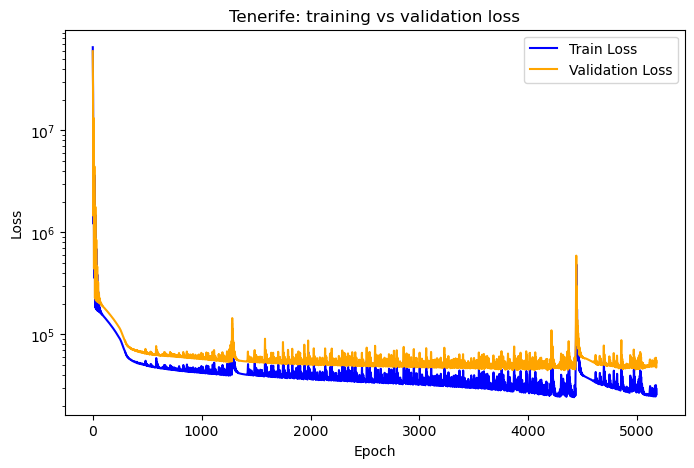

Evaluation Metrics:
R2: 0.7778995406528164
MAE: 125.5000
MSE: 38355.7591
RMSE: 195.8463
R2: 0.7779
MAPE: 0.0146
sMAPE: 0.0146




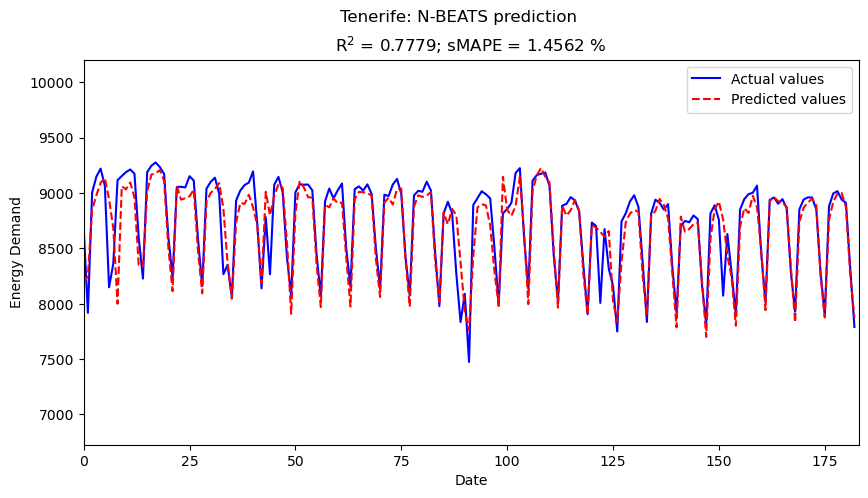



ISLA: Gran Canaria, WINDOW = 11
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=11, forecast_length=1, share_thetas=False) at @140138075901712
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=11, forecast_length=1, share_thetas=False) at @140138085995024
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=11, forecast_length=1, share_thetas=False) at @140138088004560
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=11, forecast_length=1, share_thetas=False) at @140138075644240
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=11, forecast_length=1, share_thetas=False) at @140138065047696
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=11, forecast_length=1, share_thetas=False) at @140138065032720
Epoch [500/20000], Train Loss: 47203.2383, Val Loss: 74375.6250

Epoch [1000/20000

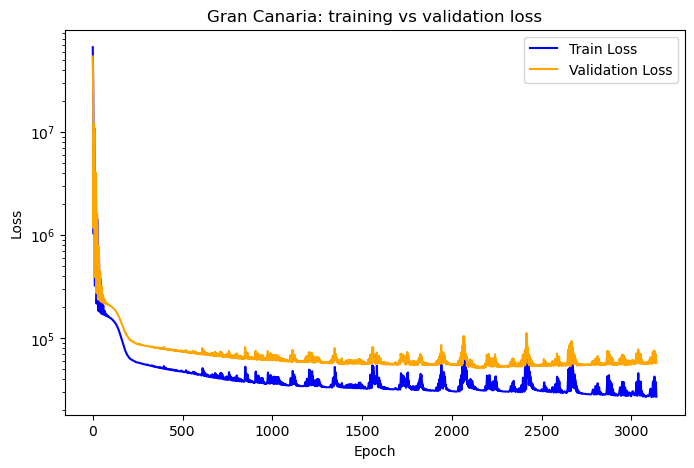

Evaluation Metrics:
R2: 0.7861434737827343
MAE: 119.2094
MSE: 38774.2615
RMSE: 196.9118
R2: 0.7861
MAPE: 0.0145
sMAPE: 0.0144




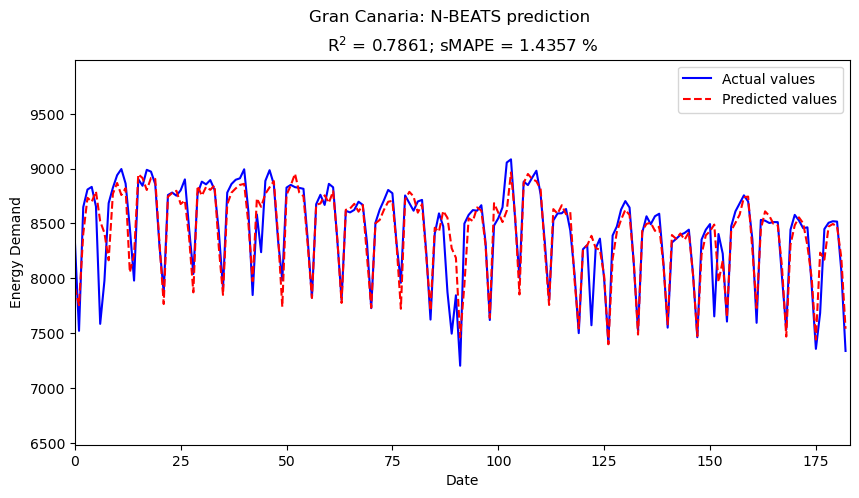



ISLA: Lanzarote, WINDOW = 11
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=11, forecast_length=1, share_thetas=False) at @140138054471888
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=11, forecast_length=1, share_thetas=False) at @140138054233168
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=11, forecast_length=1, share_thetas=False) at @140138054722448
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=11, forecast_length=1, share_thetas=False) at @140138065002448
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=11, forecast_length=1, share_thetas=False) at @140138055006864
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=11, forecast_length=1, share_thetas=False) at @140138055004560
Epoch [500/20000], Train Loss: 1909.2222, Val Loss: 2354.0518

Epoch [1000/20000], Tr

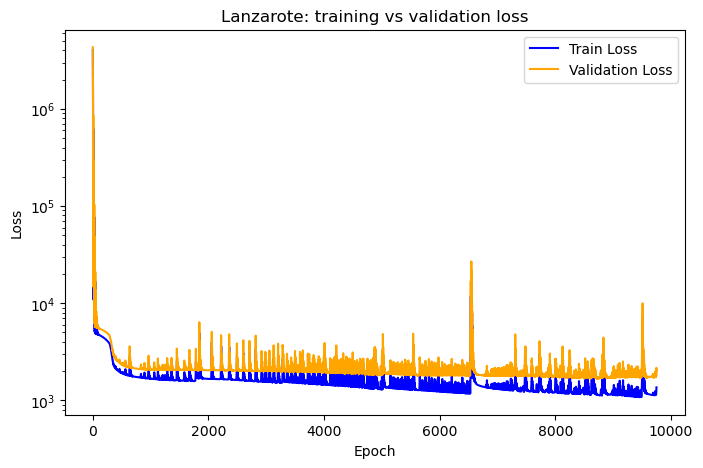

Evaluation Metrics:
R2: 0.6659957866042335
MAE: 24.0674
MSE: 1167.9254
RMSE: 34.1749
R2: 0.6660
MAPE: 0.0109
sMAPE: 0.0108




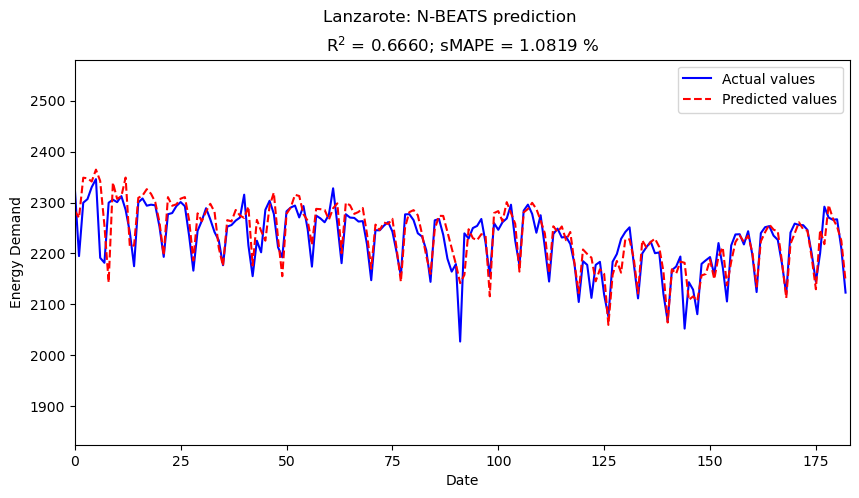



ISLA: Fuerteventura, WINDOW = 8
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=8, forecast_length=1, share_thetas=False) at @140138055007312
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=8, forecast_length=1, share_thetas=False) at @140138075796816
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=8, forecast_length=1, share_thetas=False) at @140138033491024
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=8, forecast_length=1, share_thetas=False) at @140138023550928
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=8, forecast_length=1, share_thetas=False) at @140138023550096
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=8, forecast_length=1, share_thetas=False) at @140138023540432
Epoch [500/20000], Train Loss: 971.5953, Val Loss: 1653.7708

Epoch [1000/20000], Train 

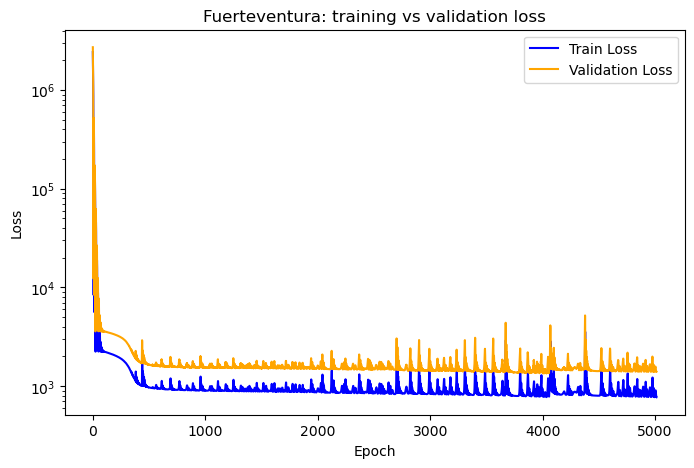

Evaluation Metrics:
R2: 0.6784480423032442
MAE: 19.9181
MSE: 753.0586
RMSE: 27.4419
R2: 0.6784
MAPE: 0.0117
sMAPE: 0.0117




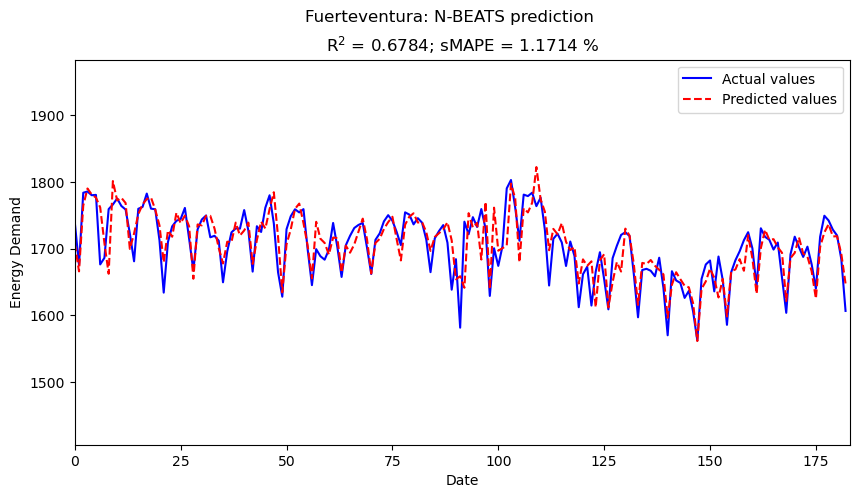



ISLA: La Palma, WINDOW = 7
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=7, forecast_length=1, share_thetas=False) at @140138012519504
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=7, forecast_length=1, share_thetas=False) at @140138044357200
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=7, forecast_length=1, share_thetas=False) at @140138033388752
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=7, forecast_length=1, share_thetas=False) at @140138033392208
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=7, forecast_length=1, share_thetas=False) at @140138012473168
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=7, forecast_length=1, share_thetas=False) at @140138023607632
Epoch [500/20000], Train Loss: 344.5520, Val Loss: 429.3966

Epoch [1000/20000], Train Loss: 

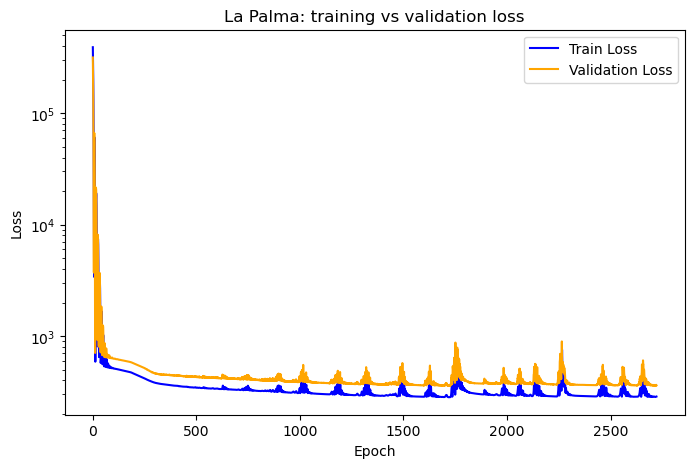

Evaluation Metrics:
R2: 0.5738979082403834
MAE: 12.1387
MSE: 274.1291
RMSE: 16.5568
R2: 0.5739
MAPE: 0.0191
sMAPE: 0.0191




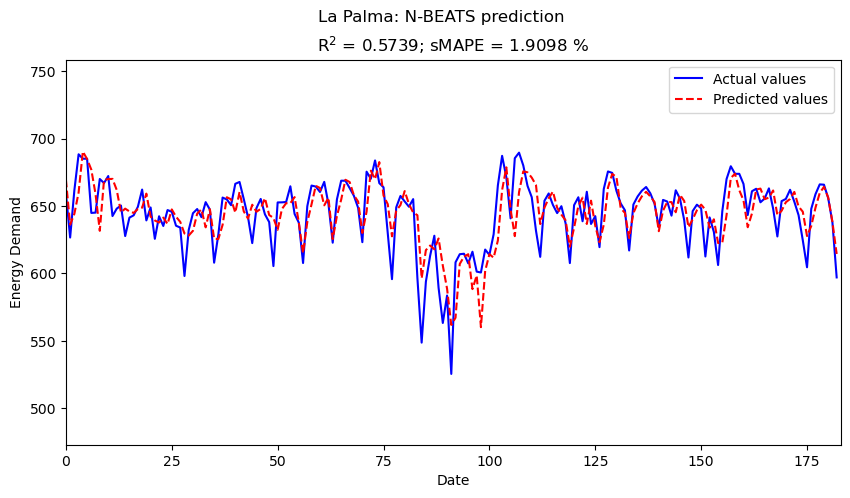



ISLA: La Gomera, WINDOW = 6
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=6, forecast_length=1, share_thetas=False) at @140138033341776
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=6, forecast_length=1, share_thetas=False) at @140138033763536
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=6, forecast_length=1, share_thetas=False) at @140138044026768
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=6, forecast_length=1, share_thetas=False) at @140138065612112
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=6, forecast_length=1, share_thetas=False) at @140138065659856
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=6, forecast_length=1, share_thetas=False) at @140138054999632
Epoch [500/20000], Train Loss: 32.3344, Val Loss: 118.3953

Epoch [1000/20000], Train Loss: 

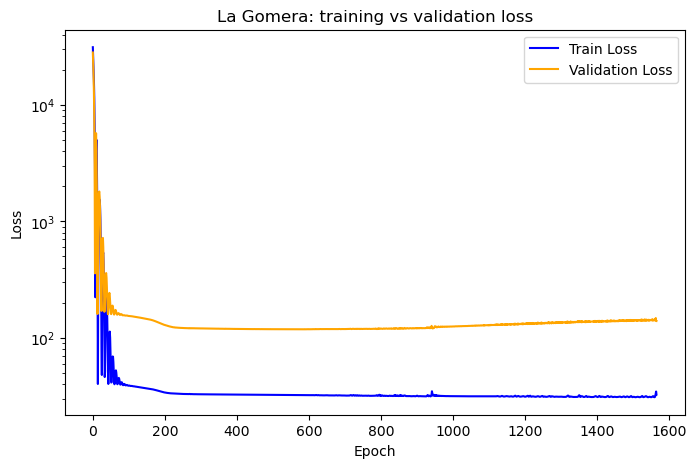

Evaluation Metrics:
R2: 0.19317695566149662
MAE: 5.3326
MSE: 47.0514
RMSE: 6.8594
R2: 0.1932
MAPE: 0.0312
sMAPE: 0.0310




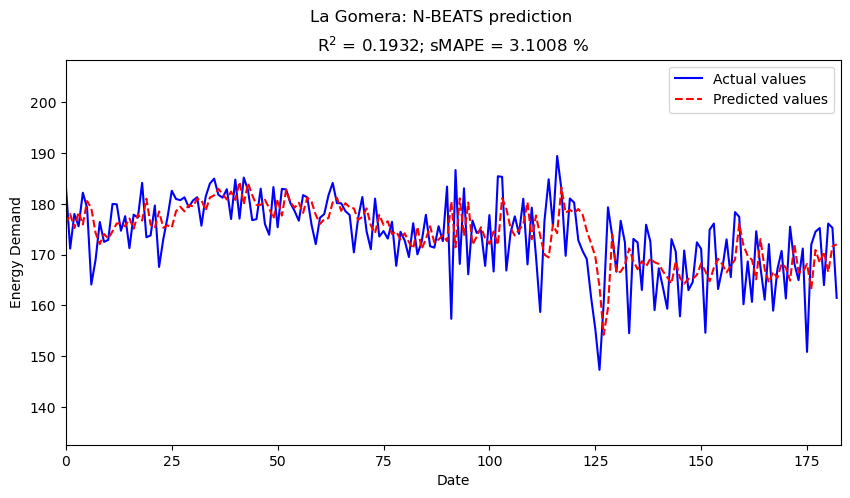



ISLA: El Hierro, WINDOW = 19
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=19, forecast_length=1, share_thetas=False) at @140138033666640
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=19, forecast_length=1, share_thetas=False) at @140138085692560
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=19, forecast_length=1, share_thetas=False) at @140138064925200
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=19, forecast_length=1, share_thetas=False) at @140138085715344
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=19, forecast_length=1, share_thetas=False) at @140138023611536
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=19, forecast_length=1, share_thetas=False) at @140138086174032
Epoch [500/20000], Train Loss: 17.9828, Val Loss: 17.1830

Epoch [1000/20000], Train 

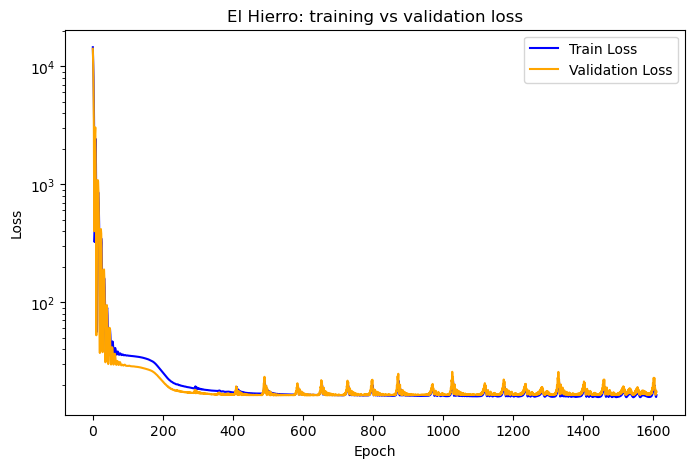

Evaluation Metrics:
R2: 0.2546619728650168
MAE: 2.7529
MSE: 14.5408
RMSE: 3.8132
R2: 0.2547
MAPE: 0.0210
sMAPE: 0.0209




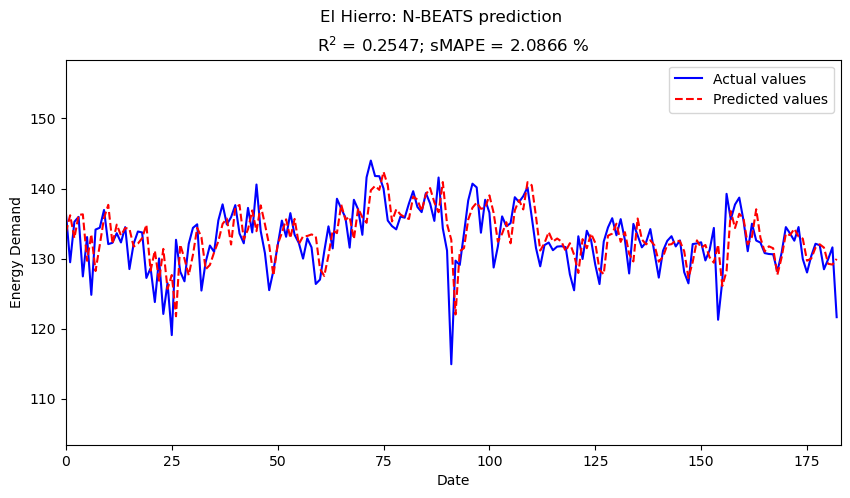

In [ ]:
# Imports
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

from src.utils import metrics
from src.utils import data_loader as d
from src.utils import models
from src.utils import sliding_window as s

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Load Data
islas_dfs = d.local_data_loader(verbose=False)

islas = ['Tenerife', 'Gran Canaria', 'Lanzarote', 'Fuerteventura', 'La Palma', 'La Gomera', 'El Hierro']
windows = [9, 11, 11, 8, 7, 6, 19]

for isla, window in zip(islas, windows):

        print(f'ISLA: {isla}, WINDOW = {window}')

        # Extract demand value
        demand = islas_dfs[isla]['OBS_VALUE'].values.reshape(-1,1) # data['energy'].values.reshape(-1, 1)

        # Data scaling
        # scaler = MaxAbsScaler()
        # demand_scaled = scaler.fit_transform(demand)

        # Training and validation
        train_size = 1460  # First 4 years for training/validation
        val_size = int(0.2 * train_size)  # 20% of training data for validation
        window_size = window 

        # Split into training, validation, and test sets
        train_data = demand[:train_size - val_size]
        val_data = demand[train_size - val_size:train_size]
        test_data = demand[train_size - window_size:]

        # Sliding window sequences for training and validation
        train_sequences, train_targets = s.create_sequences(train_data, window_size)
        val_sequences, val_targets = s.create_sequences(val_data, window_size)

        # Convert to PyTorch tensors
        train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
        train_targets = torch.tensor(train_targets, dtype=torch.float32)
        val_sequences = torch.tensor(val_sequences, dtype=torch.float32)
        val_targets = torch.tensor(val_targets, dtype=torch.float32)
        # Model training and validation
        from nbeats_pytorch.model import NBeatsNet 

        model = NBeatsNet(
            stack_types=("generic", "generic"),
            forecast_length=1,
            backcast_length=window_size,
            hidden_layer_units=128
        )

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        train_losses, val_losses = [], []
        best_val_loss = float('inf')
        stopping_counter = 0
        early_stopping = True

        num_epochs = 20_000 
        early_stopping_patience = 1_000

        for epoch in range(num_epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            _, output = model(train_sequences)
            train_loss = criterion(output, train_targets)
            train_loss.backward()
            optimizer.step()

            # Validation step
            model.eval()
            with torch.no_grad():
                _, val_output = model(val_sequences)
                val_loss = criterion(val_output, val_targets)

            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                stopping_counter = 0
            else:
                stopping_counter += 1

            if early_stopping and stopping_counter >= early_stopping_patience:
                # print("Early stopping triggered!")
                break

            if (epoch + 1) % 500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}\n')

        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(val_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.title(f'{isla}: training vs validation loss')
        plt.legend()
        plt.show()

        # Prediction
        test_sequences, test_targets = s.create_sequences(test_data, window_size)
        test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
        test_targets = torch.tensor(test_targets, dtype=torch.float32)

        # Initialize lists for storing predictions
        online_predictions = []
        actual_values = []

        # Define online optimizer and loss function
        online_optimizer = optim.Adam(model.parameters(), lr=1e-6)
        criterion = nn.MSELoss()

        # ======= 9. Online Prediction and Evaluation =======
        for i in range(len(test_sequences)):
            x = test_sequences[i].unsqueeze(0)

            # Model inference
            model.eval()
            with torch.no_grad():
                pred = model(x)[1]  # Extract the forecast output
            online_predictions.append(pred.item())
            actual_values.append(test_targets[i].item())

            # Online learning step
            model.train()
            online_optimizer.zero_grad()
            pred_online = model(x)[1]  # Extract forecast again for training
            loss_online = criterion(pred_online, test_targets[i].unsqueeze(0))
            loss_online.backward()
            online_optimizer.step()

        # online_predictions_inv = scaler.inverse_transform(np.array(online_predictions).reshape(-1, 1)).flatten()
        # actual_values_inv = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1)).flatten()

        metrics_result = metrics.all_metrics(actual_values, online_predictions)
        print("Evaluation Metrics:")
        print(f"R2: {metrics_result['R2']}")
        for metric, value in metrics_result.items():
            print(f"{metric}: {value:.4f}")
        print('\n')

        # Animation
        test_dates = islas_dfs[isla]['TIME_PERIOD_CODE'].values.reshape(-1,1)

        fig, ax = plt.subplots(figsize=(10, 5))
        plt.suptitle(f'{isla}: N-BEATS prediction')
        ax.set_xlim(0, len(actual_values))
        ax.set_ylim(min(actual_values) * 0.9, max(actual_values) * 1.1)
        ax.set_xlabel("Date")
        ax.set_ylabel("Energy Demand")
        ax.set_title(f"R$^2$ = {metrics_result['R2']:.4f}; sMAPE = {100*metrics_result['sMAPE']:.4f} %")

        ax.plot(actual_values, label = 'Actual values', color = 'blue')
        ax.plot(online_predictions, '--r' ,label = 'Predicted values')

        ax.legend()
        plt.savefig(f'nbeats_{isla}.gif')
        plt.show()
        print('\n')